In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *
import re

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [62]:
import os, codecs, string, random
# your code goes here
data_root = 'data/'
data_name = 'all_scripts.txt'

with codecs.open(os.path.join(data_root,data_name),encoding="utf8") as f:
            data = f.read()


lines = data.split("\n")

episode_pattern = r">> Series (\d{2}) Episode (\d{2})"
scene_pattern = r"^>\s*(.*)"
dialogue_pattern = r"^(\w+):\s*(.*)"

# Initialize variables
season = None
episode = None
scene = None
current_scene_id = 0
structured_data = []


for line in lines:
    line = line.strip()
    if not line:
        continue  

    episode_match = re.match(episode_pattern, line)
    if episode_match:
        season = int(episode_match.group(1))
        episode = int(episode_match.group(2))
        scene = None  # Reset scene for a new episode
        current_scene_id = 0
        continue

    # Detect a new scene
    scene_match = re.match(scene_pattern, line)
    if scene_match:
        scene = scene_match.group(1).strip()
        current_scene_id += 1
        continue

    # Detect dialogue
    dialogue_match = re.match(dialogue_pattern, line)
    if dialogue_match:
        character = dialogue_match.group(1).strip()
        dialogue = dialogue_match.group(2).strip()

        # Skip lines spoken by "All" or "Together"
        if character.lower() in ["all", "together"]:
            continue

        # Add structured row to the data
        structured_data.append({
            "Season": season,
            "Episode": episode,
            "Scene": current_scene_id,
            "Character": character,
            "Dialogue": dialogue
        })


data_df = pd.DataFrame(structured_data)
data_df

,Season,Episode,Scene,Character,Dialogue
0,1,1,1,Sheldon,So if a photon is directed through a plane wit...
1,1,1,1,Leonard,"Agreed, what’s your point?"
2,1,1,1,Sheldon,"There’s no point, I just think it’s a good ide..."
3,1,1,1,Leonard,Excuse me?
4,1,1,1,Receptionist,Hang on.
...,...,...,...,...,...
50186,10,24,14,Ramona,"Mmm. No big deal, I enjoy spending time with you."
50187,10,24,14,Sheldon,"And I with you. Question, are you seeking a ro..."
50188,10,24,14,Ramona,What if I were?
50189,10,24,14,Sheldon,"Well, that would raise a number of problems. W..."


In [56]:
# Count the number of scenes per season
scene_counts = (
    data_df[["Season", "Scene"]]
    .drop_duplicates()
    .groupby("Season")
    .size()
    .reset_index(name="Scene Count")
)

scene_counts

,Season,Scene Count
0,1,14
1,2,14
2,3,13
3,4,15
4,5,14
5,6,17
6,7,21
7,8,18
8,9,19
9,10,21


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [111]:
# your code goes here
character_appearences = data_df.groupby(["Character", "Episode"]).size()
character_appearences = character_appearences.reset_index(name="Number of Lines")
summary = character_appearences.groupby("Character").agg(
    Total_Lines=("Number of Lines", "sum"),
    Episodes_Appeared=("Episode", "nunique")
).reset_index()
summary = summary.sort_values("Episodes_Appeared", ascending=False)

summary.loc[(summary["Episodes_Appeared"] >=1) & (summary["Total_Lines"] >= 90)]

,Character,Total_Lines,Episodes_Appeared
96,Raj,4779,24
73,Leonard,9829,24
17,Bernadette,2690,24
54,Howard,5872,24
92,Penny,7677,24
106,Sheldon,11689,24
8,Amy,3472,24
113,Stuart,733,22
41,Emily,164,14
77,Man,105,13


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [131]:
%load_ext autoreload
%autoreload 2
from helpers.helper_functions import clean_text
# your code goes here
data_df["Cleaned_Dialogue"] = data_df["Dialogue"].apply(clean_text)
data_df.head(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Season,Episode,Scene,Character,Dialogue,Cleaned_Dialogue
0,1,1,1,Sheldon,So if a photon is directed through a plane wit...,so if a photon is directed through a plane wit...
1,1,1,1,Leonard,"Agreed, what’s your point?",agreed what s your point
2,1,1,1,Sheldon,"There’s no point, I just think it’s a good ide...",there s no point i just think it s a good ide...
3,1,1,1,Leonard,Excuse me?,excuse me
4,1,1,1,Receptionist,Hang on.,hang on


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

log log scale is best

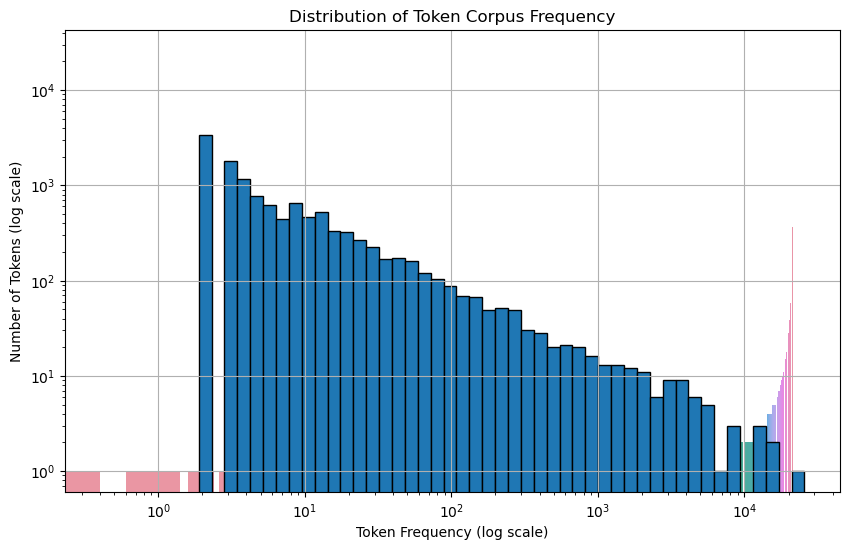

In [ ]:
from collections import Counter
import seaborn as sns
# your code goes here
all_text = data_df["Cleaned_Dialogue"].apply(simple_tokeniser)
data_df["Tokenized_Dialogue"] = data_df["Cleaned_Dialogue"].apply(simple_tokeniser)
all_tokens = [token for tokens in all_text for token in tokens]
all_tokens_count = Counter(all_tokens)
all_tokens_df = pd.DataFrame(all_tokens_count.items(), columns=["tokenito", "frequencito"])

plt.figure(figsize=(10, 6))
sns.barplot(all_tokens_df.sort_values(by="frequencito", ascending=True), x="tokenito", y="frequencito")
plt.hist(all_tokens_df["frequencito"], bins=np.logspace(0.1, np.log10(max(all_tokens_count.values())), 50), edgecolor='k')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Token Frequency (log scale)")
plt.ylabel("Number of Tokens (log scale)")
plt.title("Distribution of Token Corpus Frequency")
plt.grid(True)
plt.show()

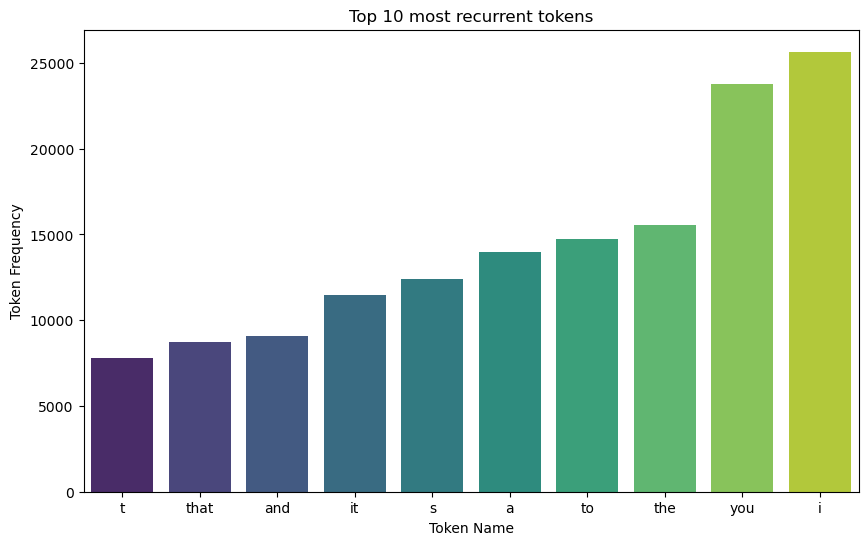

In [175]:
plt.figure(figsize=(10, 6))
sns.barplot(all_tokens_df.sort_values(by="frequencito", ascending=True).tail(10), x="tokenito", y="frequencito", palette = 'viridis')
plt.title("Top 10 most recurrent tokens")
plt.xlabel("Token Name")
plt.ylabel("Token Frequency")
plt.show()

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [190]:
# your code goes here
total_words = {}
data_df["Words Uttered"] = data_df["Tokenized_Dialogue"].apply(lambda x : len(x))
for character in recurrent_character_list:
    char_df = data_df.loc[data_df["Character"] == character]
    total_words[character] = sum(char_df["Words Uttered"])

total_words_df = pd.DataFrame(total_words.items(), columns=["Character", "Words Uttered"])
total_words_df.sort_values("Words Uttered", ascending=False)

,Character,Words Uttered
14,Sheldon,185388
8,Leonard,102496
11,Penny,79270
6,Howard,69505
13,Raj,60099
0,Amy,39933
2,Bernadette,27726
15,Stuart,7955
4,Beverley,2029
12,Priya,1940


Sheldon's the most talkative

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [210]:
data_df["Sheldon Dialogue"] = (data_df["Character"] == "Sheldon").astype(int)
data_train = data_df.loc[data_df["Season"] <= len(data_df["Season"].unique()) - 2]
data_test = data_df.loc[data_df["Season"] > len(data_df["Season"].unique()) - 2]

x_train = data_train["Cleaned_Dialogue"]
y_train = data_train["Sheldon Dialogue"]
x_test = data_test["Cleaned_Dialogue"]
y_test = data_test["Sheldon Dialogue"]

In [213]:
# your code goes here
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(
        sublinear_tf=True, stop_words="english"
    )
X_train = vectorizer.fit_transform(x_train)

X_test = vectorizer.transform(x_test)

feature_names = vectorizer.get_feature_names_out()

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.04%


**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [220]:
# your code goes here
sheldon_train_dialogues = data_train[data_train["Sheldon Dialogue"] == 1]["Cleaned_Dialogue"]
other_train_dialogues = data_train[data_train["Sheldon Dialogue"] == 0]["Cleaned_Dialogue"]

# tokenize the words in Sheldon and other characters' dialogues
sheldon_words = set(word for line in sheldon_train_dialogues for word in line.split())
other_words = set(word for line in other_train_dialogues for word in line.split())

# words unique to Sheldon
unique_sheldon_words = sheldon_words - other_words

def contains_unique_sheldon_word(dialogue, unique_words):
    tokens = set(dialogue.split())
    return any(word in tokens for word in unique_words)

data_test["Predicted Sheldon"] = data_test["Cleaned_Dialogue"].apply(
    lambda x: int(contains_unique_sheldon_word(x, unique_sheldon_words))
)

test_accuracy = accuracy_score(data_test["Sheldon Dialogue"], data_test["Predicted Sheldon"])
unique_sheldon_words_count = len(unique_sheldon_words)
test_accuracy_percentage = f"{(test_accuracy * 100):.2f}"

print(f"""
    Unique Sheldon Words Count": {unique_sheldon_words_count},
    Test Accuracy (%)": {test_accuracy_percentage}
    """)




    Unique Sheldon Words Count": 5159,
    Test Accuracy (%)": 77.95
    


/var/folders/6l/swjtq9296x5_2ys0mkblyhmh0000gn/T/ipykernel_19211/3838525307.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["Predicted Sheldon"] = data_test["Cleaned_Dialogue"].apply(
